In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
#!pip install yfinance
import yfinance as yf # https://pypi.org/project/yfinance/
import math
import random
import seaborn as sns
import datetime
import pandas as pd
from scipy import stats
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
def calculate_week_number(df_data):
    start_weekday = df_data.index[0].weekday()
    start_date = df_data.index[0]
    week_nums = []
    i = 0
    while i<len(df_data.index):
        cur_date = df_data.index[i]
        cur_week_num = ( int((cur_date- start_date).days) + start_weekday ) // 7
        week_nums.append( cur_week_num )
        i += 1
    df_data['week_num'] = week_nums
    return df_data


# get data by ticker-name, start-time & end-time
def get_df_data(ticker_name="AAPL", start_time="2022-01-01", end_time="2022-10-09"):
    df_data = yf.download(tickers=ticker_name, start=start_time, end=end_time) 
    df_data = df_data[ ["Open", "High", "Low", "Close", "Volume"] ]
    df_data['Volume_log'] = np.log2(df_data['Volume'])
    df_data['previous_Close'] = df_data['Close'].shift(1)
    df_data['daily_return'] = (df_data['Close']-df_data['previous_Close'])/df_data['previous_Close']
    df_data['overnight_return'] = (df_data['Open']-df_data['previous_Close'])/df_data['previous_Close']
    MA1, MA2 = 5, 20
    df_data['MA1'] = df_data['Close'].rolling(MA1).mean()
    df_data['MA2'] = df_data['Close'].rolling(MA2).mean()
    df_data['weekday'] = df_data.index.weekday
    df_data = calculate_week_number(df_data)
    return df_data

def merge_stocks(df_data1, df_data2):
    data = []
    i = 0
    while i<len(df_data1):
        target_time = df_data1.index[i]

        j = 0
        while j<len(df_data2):
            ref_time = df_data2.index[j]
            if ref_time>=target_time:
                break
            j += 1
        ref_time = df_data2.index[j-1]
        if ref_time<target_time:
            it1 = df_data1.iloc[i]   
            open1, high1, low1, close1 = it1['Open'], it1['High'], it1['Low'], it1['Close']
            #daily_return1 = it1['daily_return']
            #volume1 = it1['Volume']
            #target_MA1, target_MA2 = it1['MA1'], it1['MA2']
            it2 = df_data2.iloc[j-1]
            open2, high2, low2, close2 = it2['Open'], it2['High'], it2['Low'], it2['Close']
            #daily_return2 = it2['daily_return']
            #volume2 = it2['Volume']
            #ref_MA1, ref_MA2 = it2['MA1'], it2['MA2']

            tmp_list = [ target_time, open1, high1, low1, close1, ref_time, open2, high2, low2, close2 ]
            data.append( tmp_list )
            #print( target_time, ref_time )
        i += 1
    col_names = ['target_time', 'target_open', 'target_high', 'target_low', 'target_close',
                'ref_time', 'ref_open', 'ref_high', 'ref_low', 'ref_close']
    df = pd.DataFrame(data, columns = col_names)
    return df

def get_training_dataset(datetime_str, merged_data, label_name="close"):
    target_datetime = datetime.datetime.strptime(datetime_str, "%Y-%m-%d")
    i = 0
    while i<len(merged_data):
        it = merged_data.iloc[i]
        if it['target_time'] >= target_datetime:
            break
        i += 1
    tmp_df = merged_data.iloc[:i].copy()
    x_list, y_list = tmp_df["target_"+label_name], tmp_df["ref_"+label_name]
    return x_list, y_list, tmp_df

def LR_model(x_list, y_list, min_num=20, print_flag=True):
    x = list(x_list)
    y = list(y_list)
    if len(x)<min_num:
        return 1, 0, 0
    k, b, R, p, std_err = stats.linregress(x, y) # R*R -> R2
    if print_flag:
        print( '\tlinear model: y = ', round(k, 4), '* x + ', round(b, 4), "\t R2:", round(R*R, 4), "\t std error:", round(std_err, 3) )
    model_y = []
    for v in sorted(x):
        model_y.append( k*v+b )
    return k, b, R*R, model_y

time range:	 2020-01-01 - 2023-03-31
[*********************100%***********************]  1 of 1 completed
target stock:	 9988.HK 	 780
[*********************100%***********************]  1 of 1 completed
reference stock:	 BABA 	 795
merged_data:	target_time:	 2020-01-03 00:00:00 	 2023-03-01 00:00:00
merged_data:	ref_time:	 2020-01-02 00:00:00 	 2023-02-28 00:00:00
	linear model: y =  0.9913 * x +  2.8295 	 R2: 0.9605 	 std error: 0.026
open 	 ref:  88.46 	 predicted target:  90.52


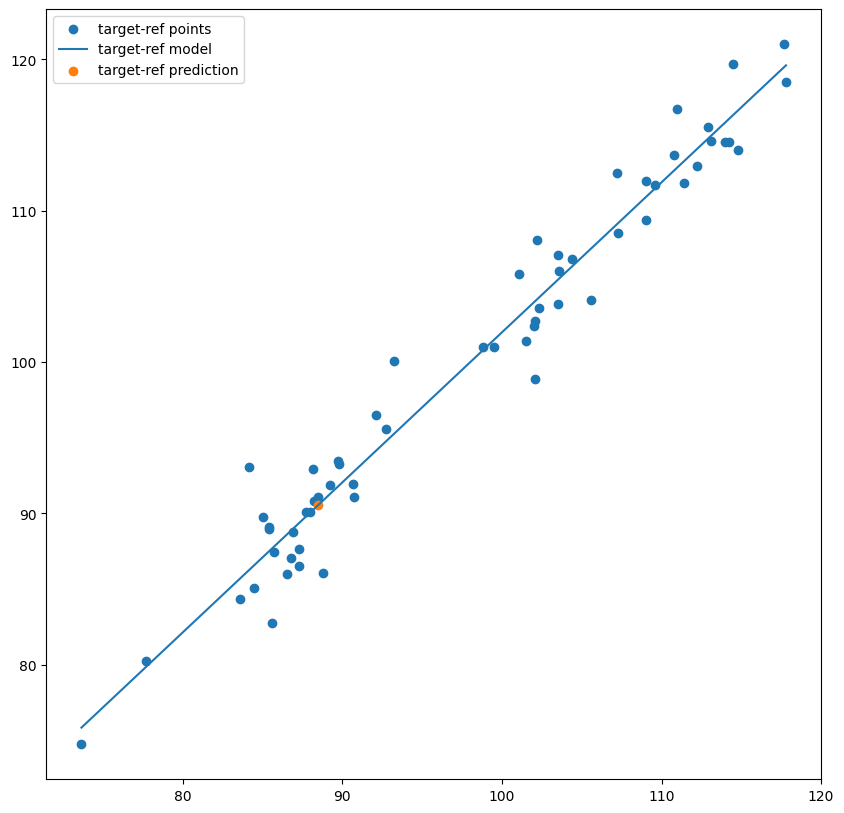

	linear model: y =  1.0196 * x +  -0.045 	 R2: 0.9741 	 std error: 0.022
low 	 ref:  87.27 	 predicted target:  88.93


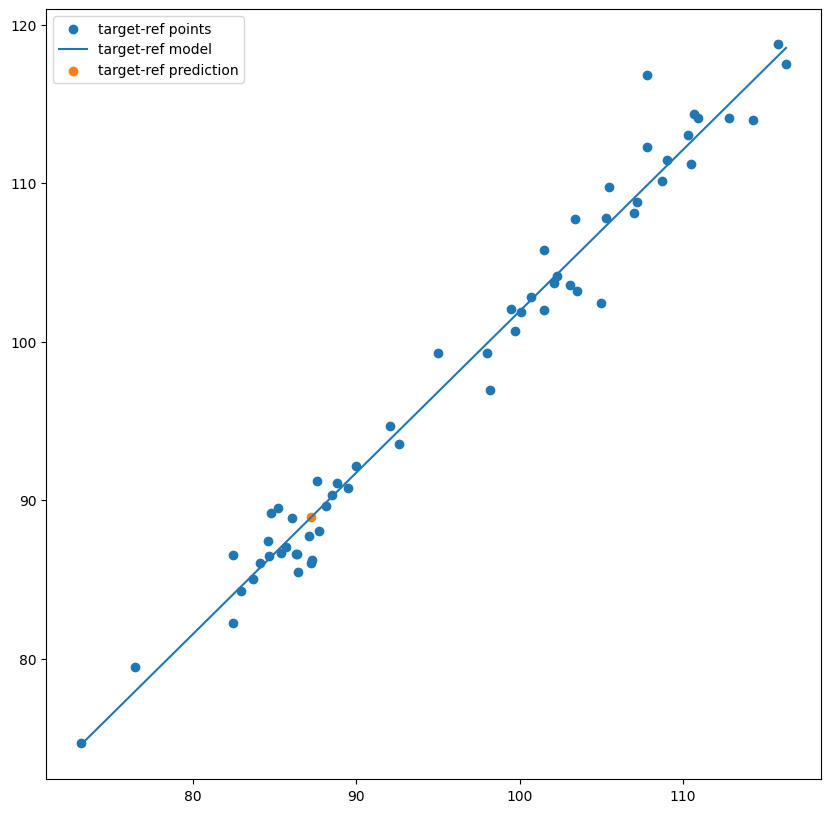

	linear model: y =  1.008 * x +  0.7977 	 R2: 0.9688 	 std error: 0.024
high 	 ref:  89.34 	 predicted target:  90.85


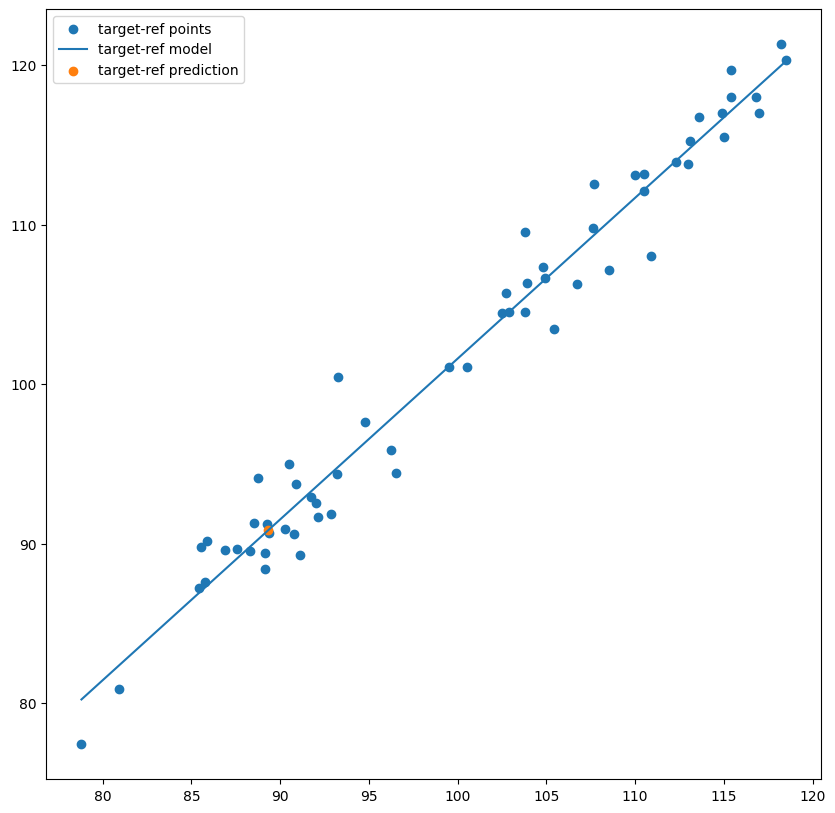

	linear model: y =  1.0235 * x +  -0.5436 	 R2: 0.9581 	 std error: 0.028
close 	 ref:  87.79 	 predicted target:  89.31


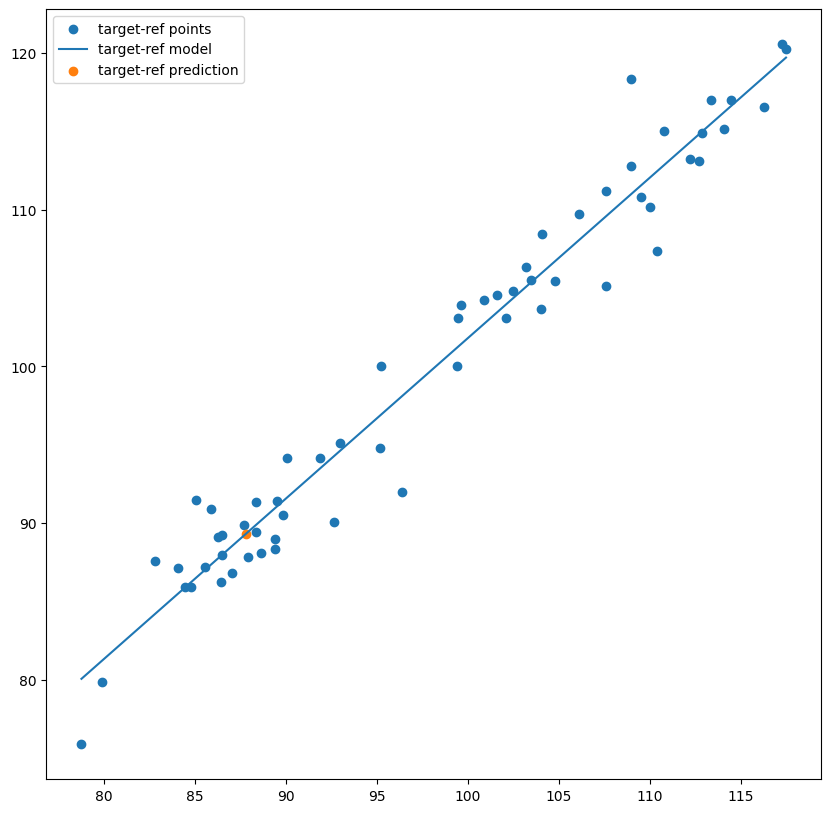

In [61]:
stocks_info = [
    ('BABA', '9988.HK', 87.79, 1),
    ('BIDU', '9888.HK', 137.69, 1),
    ('JD', '9618.HK', 44.44, 0.5 * 7.8),
    ('MPNGY', '3690.HK', 34.65, 0.5 * 7.8),
    ('NTES', '9999.HK', 77.64, 0.2 * 7.8),
    ('TCOM', '9961.HK', 35.55, 1 * 7.8),
    ('LI', '2015.HK', 23.61, 0.5 * 7.8),
    ('NIO', '9866.HK', 9.39, 1 * 7.8),
    ('ZH', '2390.HK', 1.43, 3 * 7.8)
]


for it in stocks_info[:1]: # 
    reference_stock, target_stock, st, ratio = it
    st, et = "2020-01-01", "2023-03-31"
    print("time range:\t", st, "-", et)
    df_data1 = get_df_data(ticker_name=target_stock, start_time=st, end_time=et)
    print("target stock:\t", target_stock, "\t", len(df_data1))
    df_data2 = get_df_data(ticker_name=reference_stock, start_time=st, end_time=et)
    print("reference stock:\t", reference_stock, "\t", len(df_data2))
        # merge reference-stock & target-stock: target stock (datetime, open, high, low, close), 1-day previous reference stock (datetime, open, high, low, close) 
    merged_data = merge_stocks(df_data1, df_data2)
    print("merged_data:\ttarget_time:\t", merged_data.iloc[0]['target_time'], "\t", merged_data.iloc[-1]['target_time'])
    print("merged_data:\tref_time:\t", merged_data.iloc[0]['ref_time'], "\t", merged_data.iloc[-1]['ref_time'])

    recent_ref_info = df_data2.iloc[-1]
    ref_point = {}
    ref_point['open'], ref_point['high'], ref_point['low'], ref_point['close'] = recent_ref_info['Open'], recent_ref_info['High'], recent_ref_info['Low'], recent_ref_info['Close']
    ref_point

    datetime_str = '2023-03-01'
    for label_name in ["open", "low","high", "close"]:
        x_list, y_list, tmp_df = get_training_dataset(datetime_str, merged_data, label_name)
        day_num = 60
        x_list, y_list = x_list[-day_num:], y_list[-day_num:]
        k, b, R2, model_y = LR_model(x_list, y_list, min_num=20, print_flag=True)

        pred_x = ref_point[label_name]
        pred_y = k*pred_x + b
        print( label_name, "\t", "ref: ", round(pred_x, 2), "\t", "predicted target: ", round(pred_y, 2) )

        plt.figure(figsize=(10, 10))
        plt.scatter(x_list, y_list , label="target-ref points")  # Plot the chart
        plt.plot(sorted(x_list), model_y , label="target-ref model")  # Plot the chart
        plt.scatter([pred_x], [pred_y] , label="target-ref prediction")  # Plot the chart
        plt.legend()
        plt.show()  # display